In [13]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [14]:
with open('hansard-speeches-post2010-lemmatized-agg.pkl', 'rb') as f:
    df = pickle.load(f)

In [6]:
df_test = df.sample(10000)

In [10]:
corpus = list(df_test.speech.values)

In [3]:
from sentence_transformers import SentenceTransformer

In [4]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

  0%|          | 0.00/83.4M [00:00<?, ?B/s]

In [11]:
corpus_embeddings = embedder.encode(corpus)

In [12]:
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [16]:
corpus_embeddings.shape

(10000, 384)

In [17]:
import umap

In [26]:
reducer = umap.UMAP(n_neighbors=10)

In [27]:
embedding_red = reducer.fit_transform(corpus_embeddings)

In [28]:
x, y = embedding_red.T

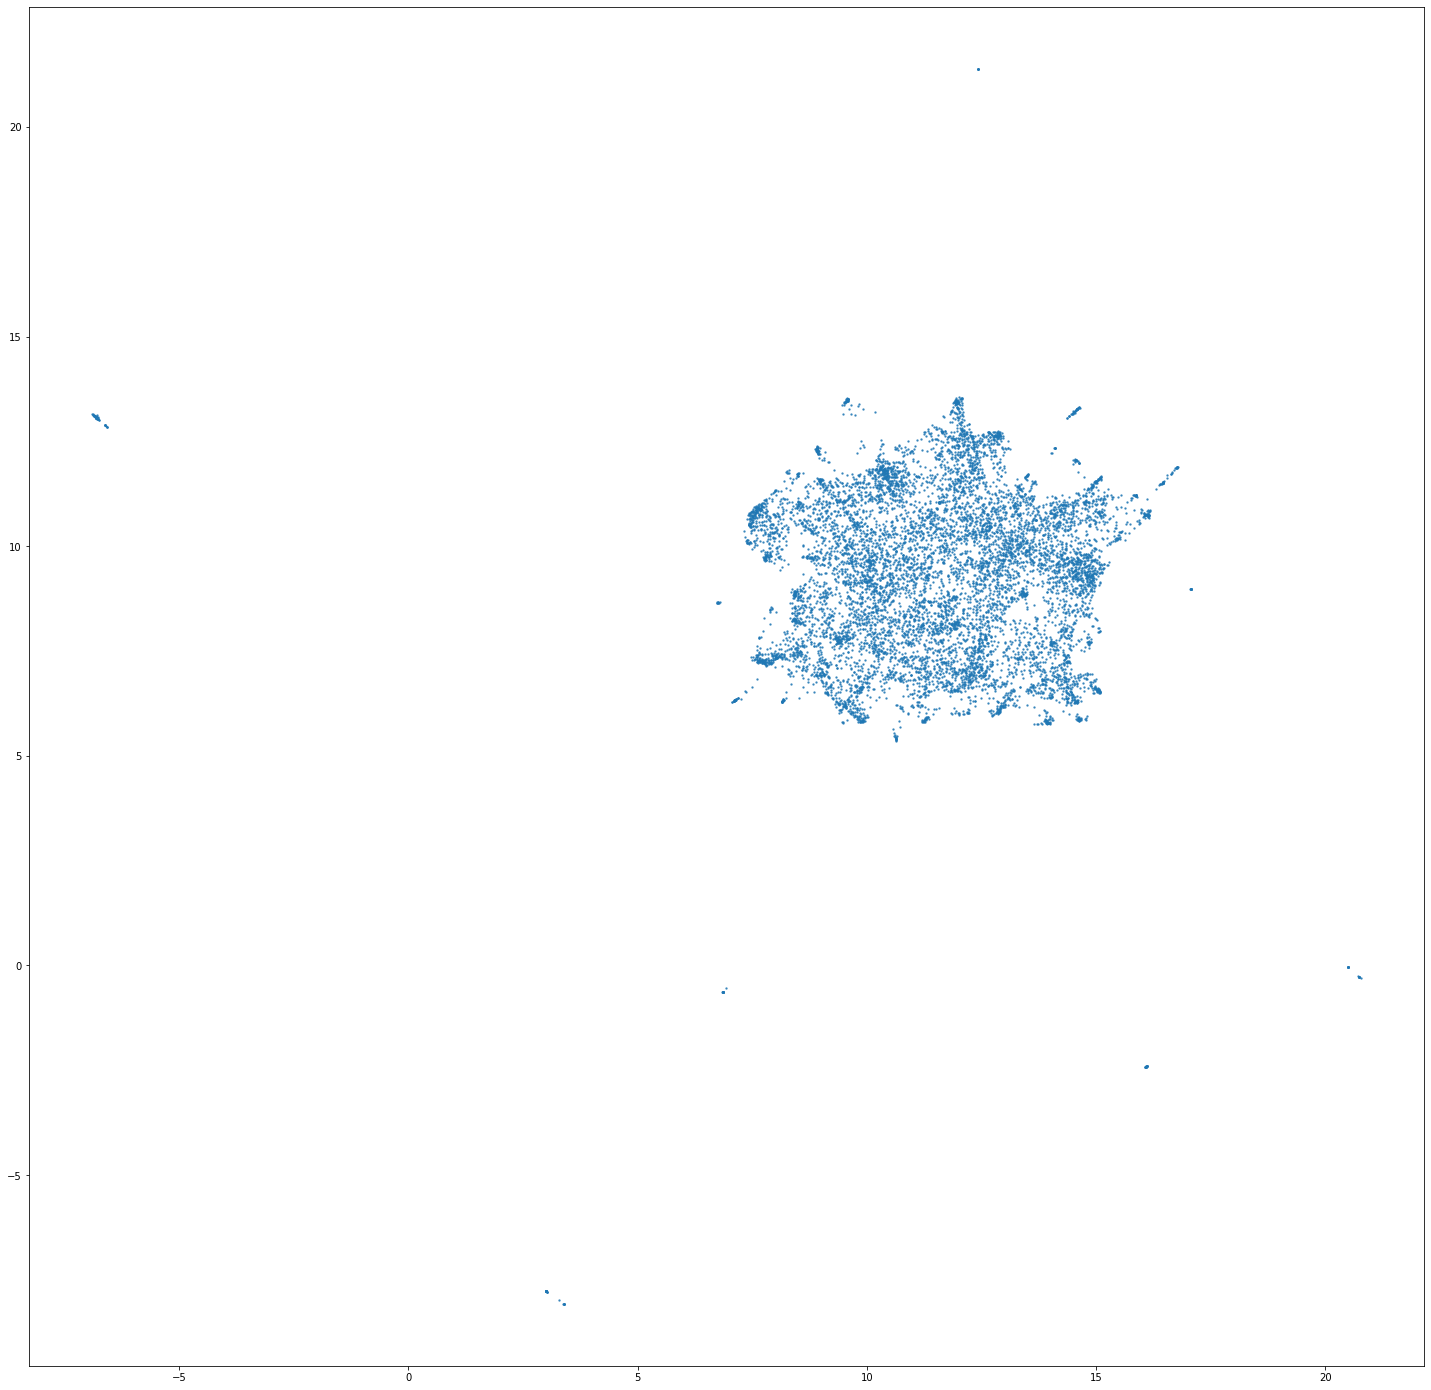

In [30]:
plt.figure(figsize=(25,25))
plt.scatter(x,y, s=2, alpha=0.7)